<a href="https://colab.research.google.com/github/Nishtha131201/Consumer-Segmentation/blob/main/Customer_Segmentation__GS_soln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#Importing dataset
df = pd.read_excel('/content/Online Retail.xlsx')

#Sampling dataset
df_fix = df.sample(10000, random_state = 42)
df_fix.shape


(10000, 8)

In [10]:
df = df[df['CustomerID'].notna()]

In [12]:
df_fix.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
47912,540456,48185,DOORMAT FAIRY CAKE,2,2011-01-07 12:14:00,7.95,13534.0,United Kingdom
342630,566891,23013,GLASS APOTHECARY BOTTLE TONIC,4,2011-09-15 13:51:00,3.95,14894.0,United Kingdom
288183,C562139,21313,GLASS HEART T-LIGHT HOLDER,-4,2011-08-03 10:10:00,0.85,12921.0,United Kingdom
325368,565438,22382,LUNCH BAG SPACEBOY DESIGN,4,2011-09-04 13:56:00,1.65,17229.0,United Kingdom
331450,566016,21212,PACK OF 72 RETROSPOT CAKE CASES,24,2011-09-08 12:20:00,0.55,15144.0,United Kingdom


In [13]:
# Convert to show date only
from datetime import datetime
df_fix["InvoiceDate"] = df_fix["InvoiceDate"].dt.date

# Create TotalSum colummn
df_fix["TotalSum"] = df_fix["Quantity"] * df_fix["UnitPrice"]

# Create date variable that records recency
import datetime
snapshot_date = max(df_fix.InvoiceDate) + datetime.timedelta(days=1)

# Aggregate data by each customer
customers = df_fix.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

# Rename columns
customers.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)

In [14]:
customers.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,40,5,133.20
12348.0,249,2,120.88
12349.0,19,2,312.75
12352.0,73,5,80.85
12354.0,233,2,33.30


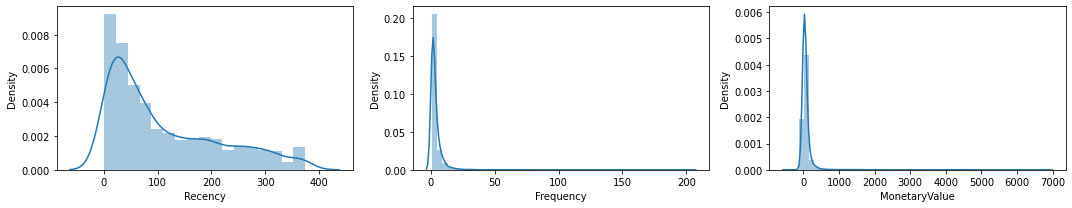

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.distplot(customers['Recency'], ax=ax[0])
sns.distplot(customers['Frequency'], ax=ax[1])
sns.distplot(customers['MonetaryValue'], ax=ax[2])
plt.tight_layout()
plt.show()

In [50]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(1, 4, figsize=(30,5))
    sns.distplot(customers[x], ax=ax[0])
    sns.distplot(np.log(customers[x]), ax=ax[1])
    sns.distplot(np.sqrt(customers[x]), ax=ax[2])
    sns.distplot(stats.boxcox(customers[x])[0], ax=ax[3])
    plt.tight_layout()
    plt.show()
    
    print(customers[x].skew().round(2))
    print(np.log(customers[x]).skew().round(2))
    print(np.sqrt(customers[x]).skew().round(2))
    print(pd.Series(stats.boxcox(customers[x])[0]).skew().round(2))

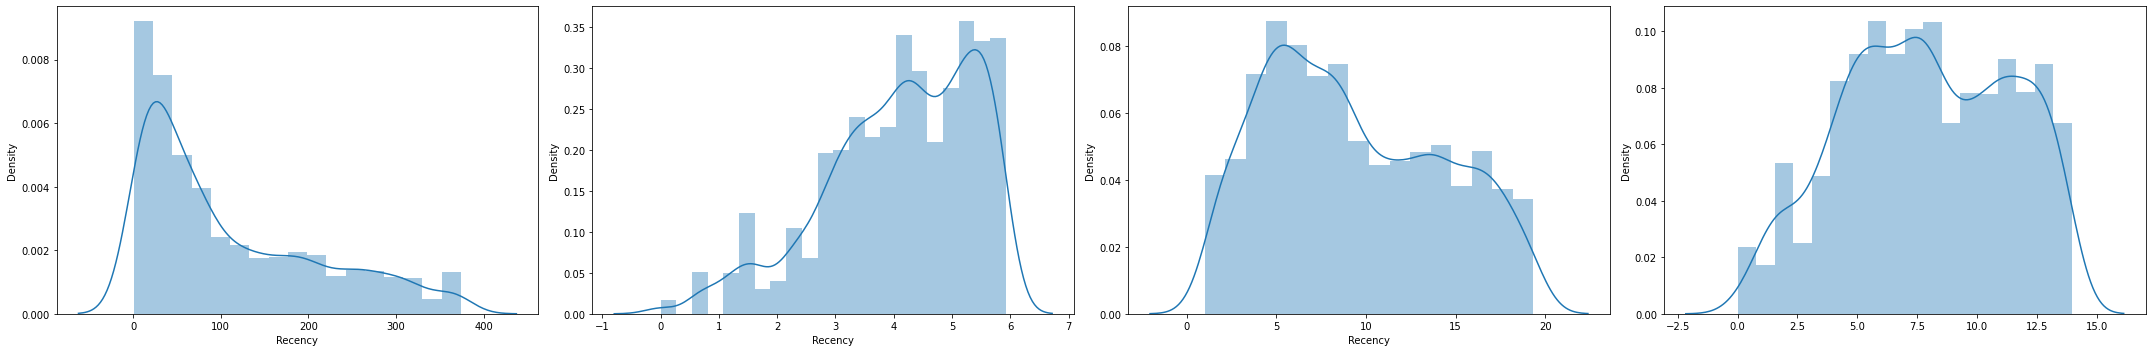

0.93
-0.72
0.32
-0.1


In [51]:
analyze_skewness('Recency')

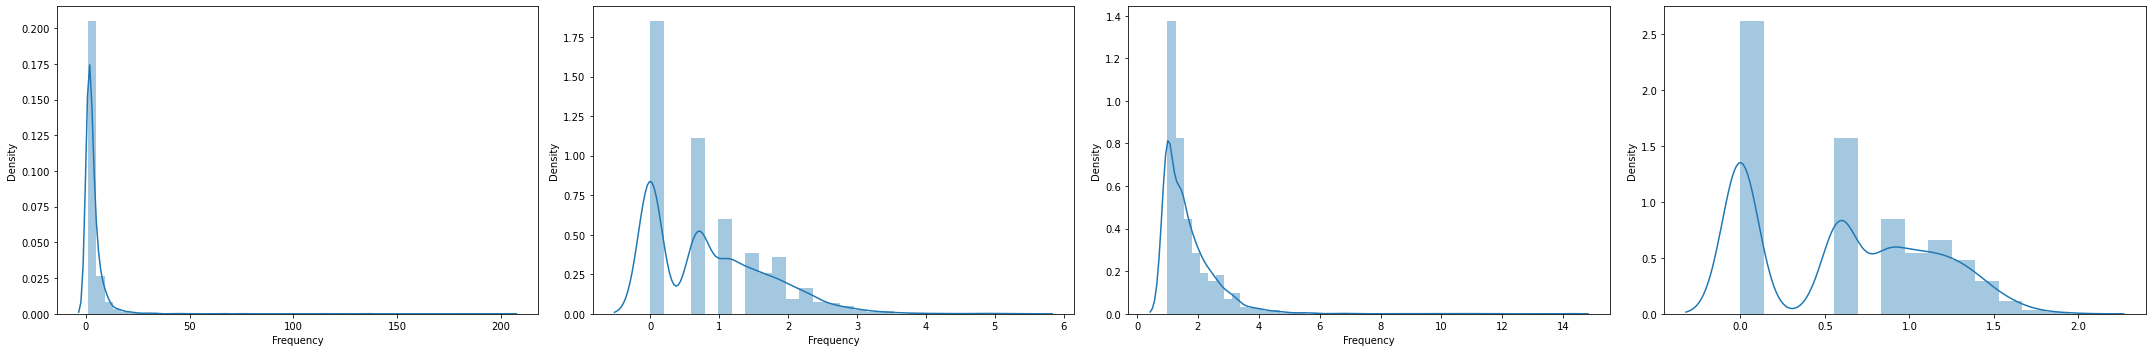

14.77
0.85
3.67
0.16


In [59]:
analyze_skewness('Frequency')


In [61]:
print("variable, log, sqrt, box-cox")
print("Recency", np.log(customers["Recency"]).skew().round(2), np.sqrt(customers["Recency"]).skew().round(2), pd.Series(stats.boxcox(customers["Recency"])[0]).skew().round(2))
print("Frequency", np.log(customers["Frequency"]).skew().round(2), np.sqrt(customers["Frequency"]).skew().round(2), pd.Series(stats.boxcox(customers["Frequency"])[0]).skew().round(2))


variable, log, sqrt, box-cox
Recency -0.72 0.32 -0.1
Frequency 0.85 3.67 0.16


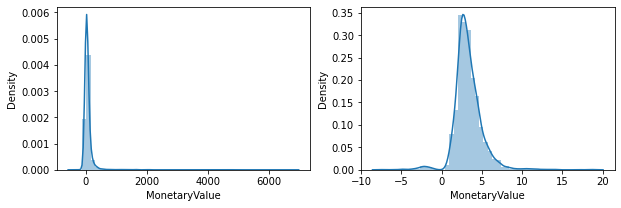

16.63
1.16


In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.distplot(customers['MonetaryValue'], ax=ax[0])
sns.distplot(np.cbrt(customers['MonetaryValue']), ax=ax[1])
plt.show()
print(customers['MonetaryValue'].skew().round(2))
print(np.cbrt(customers['MonetaryValue']).skew().round(2))

In [34]:
pd.Series(np.cbrt(customers['MonetaryValue'])).values

array([ 5.10702607,  4.94445183,  6.78785317, ..., -1.66910753,
        4.27320639,  4.0872497 ])

In [35]:
# Set the Numbers
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
2685,7.832068,0.591193,3.408514
2686,1.269495,1.435599,5.907565
2687,4.288385,0.591193,-1.669108
2688,1.665555,1.615329,4.273206
2689,6.340700,1.017445,4.087250


In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
print(customers_normalized.mean(axis = 0).round(2))
print(customers_normalized.std(axis = 0).round(2))

[ 0. -0.  0.]
[1. 1. 1.]


In [37]:
pd.DataFrame(customers_normalized).head()

,0,1,2
0,-0.493794,1.012426,1.017503
1,1.232949,-0.017412,0.925115
2,-0.994917,-0.017412,1.972690
3,-0.012582,1.012426,0.572565
4,1.155005,-0.017412,-0.056441


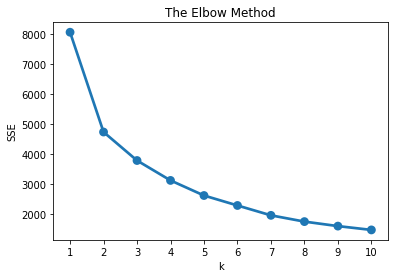

In [38]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [39]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(2690,)

In [40]:
customers.shape

(2690, 3)

In [41]:
customers["Cluster"] = model.labels_
customers.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347.0,40,5,133.20,2
12348.0,249,2,120.88,1
12349.0,19,2,312.75,2
12352.0,73,5,80.85,2
12354.0,233,2,33.30,1


In [62]:
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         47.29      1.61         21.57   808
1        226.77      1.64         28.67   959
2         46.29      7.72        165.91   923

In [43]:
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
df_normalized.head()

,Recency,Frequency,MonetaryValue,ID,Cluster
0,-0.493794,1.012426,1.017503,12347.0,2
1,1.232949,-0.017412,0.925115,12348.0,1
2,-0.994917,-0.017412,1.972690,12349.0,2
3,-0.012582,1.012426,0.572565,12352.0,2
4,1.155005,-0.017412,-0.056441,12354.0,1


In [44]:
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Frequency','MonetaryValue','Recency'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,12347.0,2,Frequency,1.012426
1,12348.0,1,Frequency,-0.017412
2,12349.0,2,Frequency,-0.017412
3,12352.0,2,Frequency,1.012426
4,12354.0,1,Frequency,-0.017412


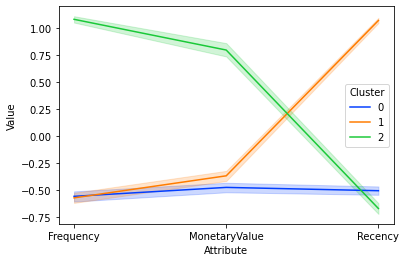

In [64]:
#snake plot
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt,palette="bright")

In [46]:
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          47.3       1.6          21.6   808
1         226.8       1.6          28.7   959
2          46.3       7.7         165.9   923

In [47]:
cluster_avg = customers.groupby('Cluster').mean()
population_avg = customers.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp

,Cluster,Frequency,MonetaryValue,Recency
Cluster,,,,
0,NaN,-0.566204,-0.707029,-0.573681
1,NaN,-0.557931,-0.610662,1.044171
2,NaN,1.075351,1.253417,-0.582693
